# High-dimensional analysis with pytometry
## Table of contents
1. [What is pytometry?](#pytometry)
2. [Reading in data](#reading-in-data)
3. [Transforming channel values](#transforming-channel-values)
4. [Adding sample metadata](#adding-sample-metadata)
5. [Batch alignment](#batch-alignment)  
6. [Clustering](#clustering)  
7. [Batch alignment](#batch-alignment)  

## What is pytometry?
`Pytometry` is a Python package that provides tools for reading in flow cytometry data and applying pre-processing tools. While it provides methods for compensation and transformation (just like `flowkit`), it's focus is on the high-dimensional and unsupervised analysis of cytometry data. 'Pytometry' uses a data structure called `AnnData` ("Annotated Data") that is commonly used for single cell analysis, most notably the `scanpy` package often used for RNAseq analysis. This allows us to apply algorithms and visualisations to our cytometry data from the transcriptomics world. The AnnData structure may seem a little intimiating at first, but we'll learn as we go, and hopefully you'll see it's just a collection of matrices/DataFrames of different kinds of data, all linked back to the data by the sample metadata.

In the diagram below (from the `AnnData` package's documentation): 
- `X` is the expression matrix where each row is an event and each column is a variable
- `var` is a DataFrame of metadata about each variable in `X`
- `obs` is a DataFrame of metadata about each observation (event) in `X`
- `uns` is a dictionary of unstructured metadata that doesn't fit anywhere else

There are some other subfields in the diagram that either aren't relevant for not, or we'll come back to them later.

<img alt="annData" src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" width=500>

Note: `pytometry` assumes your data have already been cleaned of debris, dead cells, and doublets. Most people will find it easiest to do this using software like FlowJo and exporting cleaned .fcs or .csv files. Alternatively this can be done in `flowkit` as in the previous tutorial.

We start by importing the packages we're going to need. There are quite a lot of them in this tutorial so you may wish to take note of the alias we use for each. Don't forget that before using these packages you will need to install them, for example using `pip install bokeh pytometry` in a terminal/powershell.

In [1]:
import scanpy as sc             # for single cell analysis
import anndata as ann           # for annotated data structure
import cytonormpy as cnp        # for correcting batch effects
import numpy as np              # for numpy arrays
import pandas as pd             # for pandas dataframes
import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for more plotting functions
import joypy                    # for making ridgeplots
import pytometry as pm          # for high-dim cytometry functions
import os                       # for working with directories

## Reading in data
For this tutorial, you should have the 16 example .fcs files in the folder data/clean from your working/project directory. You can check this using the `os.listdir()` function as below. You should see the same output as shown here.

In [2]:
path = 'data/clean/'
files = os.listdir(path)
files

['Mock_01_A.fcs',
 'Mock_02_A.fcs',
 'Mock_03_A.fcs',
 'Mock_04_A.fcs',
 'Mock_05_B.fcs',
 'Mock_06_B.fcs',
 'Mock_07_B.fcs',
 'Mock_08_B.fcs',
 'sample_details.csv',
 'Virus_01_A.fcs',
 'Virus_02_A.fcs',
 'Virus_03_A.fcs',
 'Virus_04_A.fcs',
 'Virus_05_B.fcs',
 'Virus_06_B.fcs',
 'Virus_07_B.fcs',
 'Virus_08_B.fcs']

We'll make use of that .csv file later, but for now let's get a list containing just the .fcs file names.

In [3]:
files = [fileID for fileID in files if fileID.endswith(".fcs")]
files

['Mock_01_A.fcs',
 'Mock_02_A.fcs',
 'Mock_03_A.fcs',
 'Mock_04_A.fcs',
 'Mock_05_B.fcs',
 'Mock_06_B.fcs',
 'Mock_07_B.fcs',
 'Mock_08_B.fcs',
 'Virus_01_A.fcs',
 'Virus_02_A.fcs',
 'Virus_03_A.fcs',
 'Virus_04_A.fcs',
 'Virus_05_B.fcs',
 'Virus_06_B.fcs',
 'Virus_07_B.fcs',
 'Virus_08_B.fcs']

The next step is to read these .fcs files into a list of AnnData objects. First we create an empty list that will hold the data, then we iterate over each filename, reading in the data with the `pm.io.read_fcs()` function, removing unwanted parameters with the `pm.pp.split_signal()` function, then adding that data to the list using the `append()` method. If you call `?pm.pp.split_signal` you'll see this function removes any non-area parameters if `data_type = 'facs'` and removes any non-element parameters if `data_type = 'cytof'`.

In [4]:
adatas = []

for fileID in files:

    adata = pm.io.read_fcs(path + fileID)

    pm.pp.split_signal(
        adata, 
        var_key   = "channel", 
        data_type = "facs"
    )

    adatas.append(adata)

We can subset `adatas` just like any list. If we look at just the first element, we're told it's an AnnData object with 10,000 events and 8 parameters. 

In [5]:
adatas[0]

AnnData object with n_obs × n_vars = 10000 × 8
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    uns: 'meta'

We're also told this object has a DataFrame of variable-level metadata (`var`), and some unstructured metadata (`uns`). We can access the variable-level metadata by calling the `var` attribute, and we see we get a DataFrame with some information about each parameter in the original .fcs file. The unstructured metadata just contains the original .fcs file keyword data, and can be accessed using the `.uns` attribute.

In [6]:
adatas[0].var

n    channel   marker  $PnB $PnE $PnG    $PnR signal_type
CD3e     1  PECy5-5-A     CD3e    32  0,0  1.0  262144        area
CD16-32  2    PECy7-A  CD16-32    32  0,0  1.0  262144        area
Ly6G     3    DL800-A     Ly6G    32  0,0  1.0  262144        area
CD45     4    AF700-A     CD45    32  0,0  1.0  262144        area
CD48     5   APCCy7-A     CD48    32  0,0  1.0  262144        area
CD11b    6   BUV395-A    CD11b    32  0,0  1.0  262144        area
B220     7   BUV737-A     B220    32  0,0  1.0  262144        area
Ly6C     8    BV605-A     Ly6C    32  0,0  1.0  262144        area

In [7]:
adatas[0].uns

OrderedDict([('meta',
              {'__header__': {'FCS format': 'FCS3.1',
                'text start': 256,
                'text end': 909,
                'data start': 910,
                'data end': 320909,
                'analysis start': 0,
                'analysis end': 0},
               '$BEGINANALYSIS': '0',
               '$BEGINDATA': '910',
               '$BEGINSTEXT': '0',
               '$BYTEORD': '1,2,3,4',
               '$DATATYPE': 'F',
               '$ENDANALYSIS': '0',
               '$ENDDATA': '320909',
               '$ENDSTEXT': '0',
               '$MODE': 'L',
               '$NEXTDATA': 0,
               '$PAR': 8,
               '$TOT': 10000,
               'channels':         $PnN     $PnS  $PnB $PnE $PnG    $PnR
               n                                            
               1  PECy5-5-A     CD3e    32  0,0  1.0  262144
               2    PECy7-A  CD16-32    32  0,0  1.0  262144
               3    DL800-A     Ly6G    32  0,0  1.0  

At present our data are stored as a list of AnnDatas but it will be more convenient if we can merge these into a single master AnnData. We can achieve this using the `.concat()` method. The `label` argument defines the name of the new column in the observation-level metadata (`obs`) that will indicate the filename each event belongs to, and the `keys` argument defines what these values will be. The `merge = 'same'` argument tells the function to keep only the `var` and `uns` metadata if it is the same for all samples. This ensures that all samples have the same parameters, but results in the `uns` matrix being dropped as this is different for each sample (but we don't mind that).

In [8]:
adata_all = ann.concat(
    adatas, 
    label = 'filename', 
    keys  = files, 
    merge = 'same'
)

adata_all

c:\Python_3.10.2\lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 160000 × 8
    obs: 'filename'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'

Let's take a look at this observation-level metadata I just mentioned. We can view it by calling the `obs` attribute of our object. At present we just have the `filename` column we created to indicate the file each even belongs to. Later we will add more metadata like experimental group and batch.

In [9]:
adata_all.obs

filename
0      Mock_01_A.fcs
1      Mock_01_A.fcs
2      Mock_01_A.fcs
3      Mock_01_A.fcs
4      Mock_01_A.fcs
...              ...
9995  Virus_08_B.fcs
9996  Virus_08_B.fcs
9997  Virus_08_B.fcs
9998  Virus_08_B.fcs
9999  Virus_08_B.fcs

[160000 rows x 1 columns]

As a quick sense-check, let's see how many events we have for each value of the `filename` column in `obs`:

In [10]:
adata_all.obs['filename'].value_counts()

Mock_01_A.fcs     10000
Mock_02_A.fcs     10000
Mock_03_A.fcs     10000
Mock_04_A.fcs     10000
Mock_05_B.fcs     10000
Mock_06_B.fcs     10000
Mock_07_B.fcs     10000
Mock_08_B.fcs     10000
Virus_01_A.fcs    10000
Virus_02_A.fcs    10000
Virus_03_A.fcs    10000
Virus_04_A.fcs    10000
Virus_05_B.fcs    10000
Virus_06_B.fcs    10000
Virus_07_B.fcs    10000
Virus_08_B.fcs    10000
Name: filename, dtype: int64

We can see we have 10,000 events per file. We won't always have the same number of events per sample, but it's good to check we have what we expect, and to ensure we don't have files with too few events.

## Transforming channel values
If your data were exported from FlowJo, then all the parameters will be linear. In order for our dimension reduction and clustering algorithms to provide meaningful insights, we need to transform our fluorescence/metal parameters. `Pytometry` provides a few common transformations such as *biexponential*, *logicle*, and *asinh*. The asinh (inverse hyperbolic sin) transformation is almost exclusively used for mass cytometry data, while any of these transformations may be applied to fluorescence cytometry data. You can experiment with different transformations, but for today we will use biexponential.

We do that using the `normalize_biexp()` function, giving the AnnData object, and s eries of parameters to the transformation. You can experiment with these paremeters, but I took these particular values directly from FlowJo. There is also a `normalize_autologicle()` function for automatically choosing the parameters of a logicle transformation, but I'll let you experiment with that one. These functions modify the values of the axisting AnnData object in place.

In [11]:
pm.tl.normalize_biexp(
    adata_all,
    negative  = 0,
    width     = -100,
    positive  = 3.71,
    max_value = 65536
)

#pm.tl.normalize_autologicle(adata_all)

To check our choice of transformation is suitable, it’s a good idea to plot each transformed parameter. A quick way to check if our negative populations are squeezed or split by the transformation, is to create ridge plots (sometime called joyplots). We do this using the `joyplot()` function from the package of the same name. This function doesn't accept AnnData objects as input, so we convert the expression data to a DataFrame using `to_df()` then randomly sample 10,000 events to speed the plotting up. To the `column` argument we give a list of variable names we access from the `var_names` attribute (converting it to a list as is expected by `joyplot()`), where every variable will be plotted as a separate distribution. The `overlap` argument just controls how much the distributions overlap and you can experiment with this.


I start by using the do.subsample() function to randomly sample 10,000 events from the data (just to speed things up). Next, I use lapply() to apply a function to every element in our transformed_cols vector. The function I apply is an anonymous function that calls make.colour.plot() on the data, iterating over each element of the transformed_cols vector as the x variable, and fixing “AF700_CD45_asinh” as the y variable.

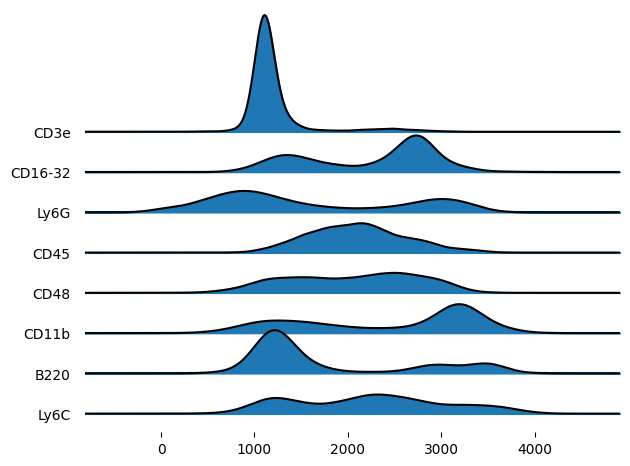

In [12]:
p = joypy.joyplot(
    adata_all.to_df().sample(10_000),
    column  = adata.var_names.to_list(),
    overlap = 1.5
)

Those negative populations look ok, but looking at bivariate plots is a good idea too. Below, we use `seaborn`'s `histplot()` function for plotting a 2D histogram of CD45 against every other parameter. We extract the expression data as a `numpy` array by calling the `X` (capital X) attribute from our AnnData object (or we could have extracted it as a DataFrame as we did above). We iterate over the parameters, subsetting for the column for the current parameter.

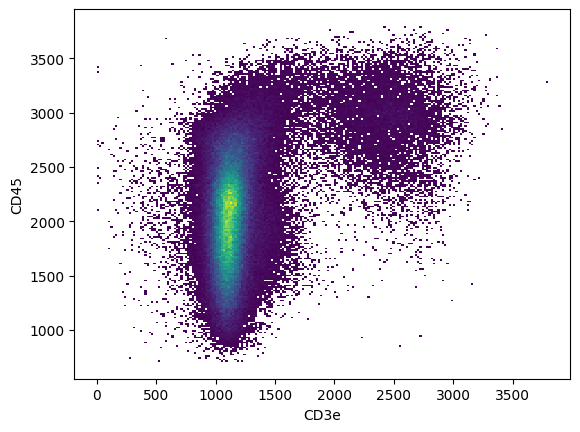

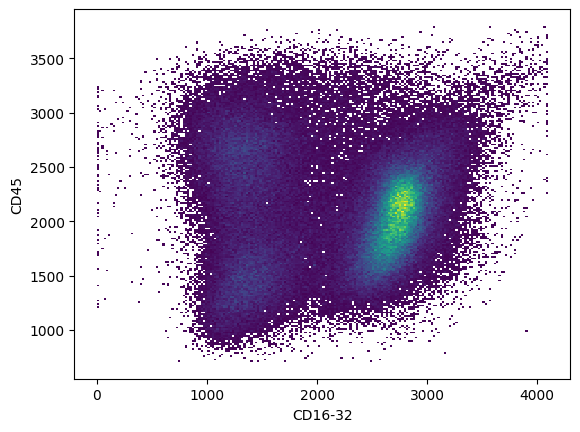

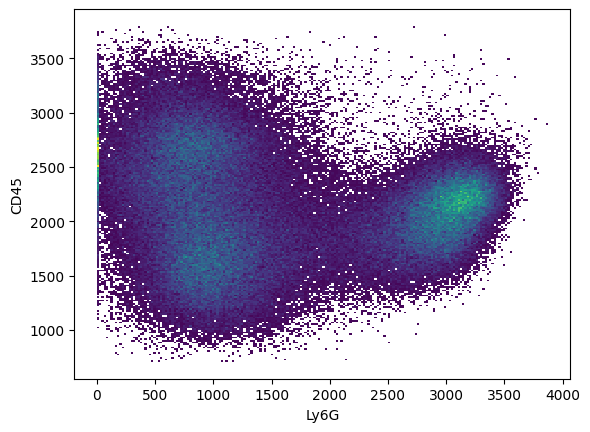

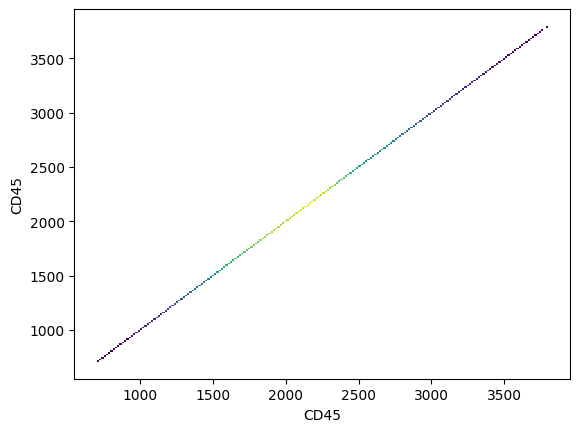

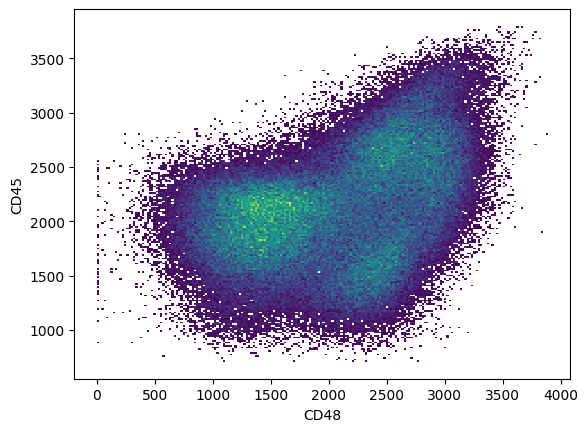

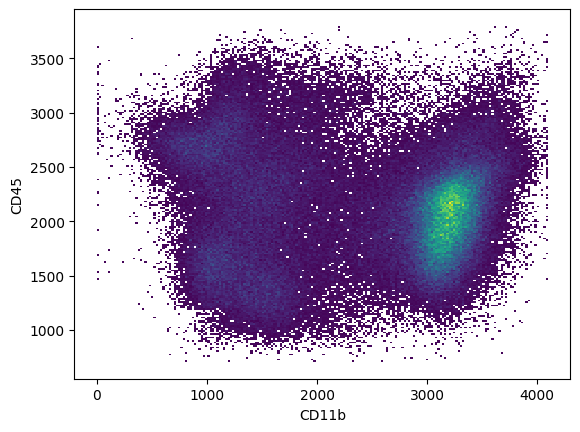

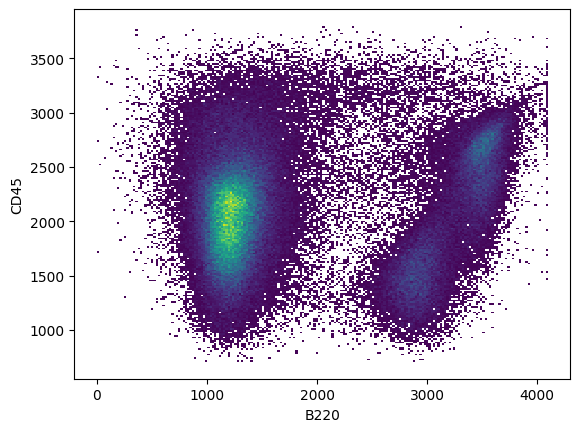

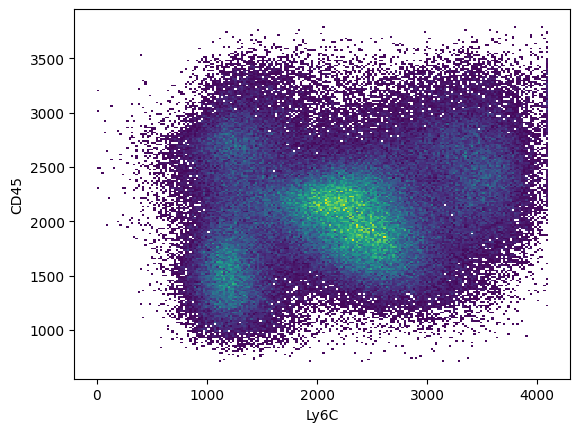

In [13]:
for idx, name in enumerate(adata_all.var_names):
    p = sns.histplot(
        x = adata_all.X[:, idx],
        y = adata_all.X[:, 3],
        bins = 200,
        cmap = 'viridis'
    )

    plt.xlabel(name)
    plt.ylabel('CD45')
    plt.show()

After inspecting each of the plots, we may wish to go back and change our transformation. This transformation looks fine, so we’ll continue.

## Adding sample metadata
Often, we will have sample metadata we wish to include in our analysis that couldn’t read in as part of our .fcs files. This might include sample identifiers and grouping variables such as treatment, concentration, and time. It’s easy to add this information to our `AnnData` object by manually creating a .csv file with the relevant information, and merging this with the `obs` DataFrame.

In your `data/clean/` directory, you should have the file "sample_details.csv" that contains the metadata for this example. If you open the file as a spreadsheet, you'll see it contains the columns:

- filename
- sample
- group
- batch_label
- batch
- reference

It doesn’t need all of these, and could contain more, depending on what variables you want to use to annotate your samples (you could include donor age, for example). However note that (at the time of writing this) the cytonorm algorithm does expect the column `batch` to contain only integers and the column `reference` to containg the value `'ref'` for reference controls, and `'other'` for non-reference controls (more on all of this later).

We read this .csv file in as a DataFrame and merge it with the `obs` DataFrame, matching the metadata between the files using the `filename` column. You can think of it as taking each row in `obs` in turn, looking at the `filename`, then grabbing the metadata corresponding to that `filename` in `metadata`.

In [14]:
metadata = pd.read_csv('data/clean/sample_details.csv')
metadata

filename     sample  group batch_label  batch reference
0    Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
1    Mock_02_A.fcs  Mock_02_A   Mock           A      1     other
2    Mock_03_A.fcs  Mock_03_A   Mock           A      1     other
3    Mock_04_A.fcs  Mock_04_A   Mock           A      1     other
4   Virus_01_A.fcs   WNV_01_A  Virus           A      1     other
5   Virus_02_A.fcs   WNV_02_A  Virus           A      1     other
6   Virus_03_A.fcs   WNV_03_A  Virus           A      1     other
7   Virus_04_A.fcs   WNV_04_A  Virus           A      1     other
8    Mock_05_B.fcs  Mock_05_B   Mock           B      2       ref
9    Mock_06_B.fcs  Mock_06_B   Mock           B      2     other
10   Mock_07_B.fcs  Mock_07_B   Mock           B      2     other
11   Mock_08_B.fcs  Mock_08_B   Mock           B      2     other
12  Virus_05_B.fcs   WNV_05_B  Virus           B      2     other
13  Virus_06_B.fcs   WNV_06_B  Virus           B      2     other
14  Virus_07_B.fcs   WNV_07_B  Virus           B      2     other
15  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other

In [15]:
adata_all.obs = pd.merge(adata_all.obs, metadata, on = 'filename', how = 'left')

c:\Python_3.10.2\lib\site-packages\anndata\_core\anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


We get a little warning from `AnnData` telling us it likes the index (the rownames) of `obs`to be strings, but the `merge()` function returned integers. We fix that easily below and look at our newly added metadata.

In [16]:
adata_all.obs.index = adata_all.obs.index.astype(str)
adata_all.obs

filename     sample  group batch_label  batch reference
0        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
1        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
2        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
3        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
4        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref
...                ...        ...    ...         ...    ...       ...
159995  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other
159996  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other
159997  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other
159998  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other
159999  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other

[160000 rows x 6 columns]

## Batch alignment
If samples were not all stained and collected together, it’s possible that batch effects exist in the data that contribute added noise. Preventing batch effects before they occur is the best strategy, but if samples must be collected at distant time points, then we can mitigate their impact by including a common sample to each round of staining and acquisition, and using the CytoNorm algorithm to align the batches based on these *batch control* files.

Let's start by looking for evidence of a batch effect between our two batches. A fairly effective way of doing this is to find a lower-dimensional representation of the data, and visualize it to see if batches are overlapping. We'll use the UMAP dimension reduction algorithm for this.

To speed things up, we start by taking a random sample of 50,000 events from our AnnData object and storing this in a new AnnData object called `adata_sub`. Before running UMAP, we must calculate the distance between each event and its nearest neighbors using `sc.pp.neighbors()`. We then calculate the UMAP embedding with `sc.tl.umap()`, where `min_dist` controls the granularity of the final embedding. Finally, we can plot the embedding using `sc.pl.umap()`, giving a list of variable sfrom `obs` we wish to colour by (each resulting in a subplot).

c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


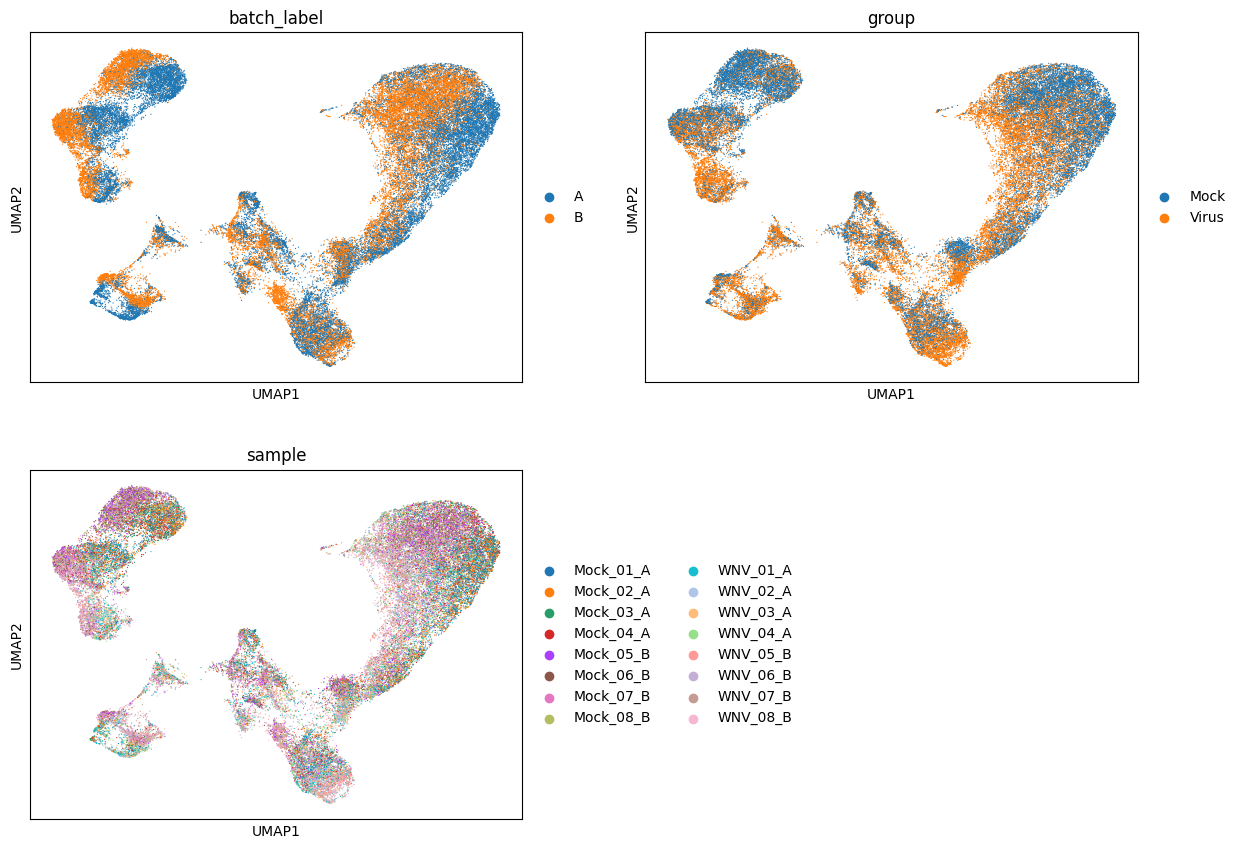

In [17]:
adata_sub = sc.pp.subsample(adata_all, n_obs = 50_000, copy = True)

sc.pp.neighbors(adata_sub)

sc.tl.umap(adata_sub, min_dist = 0.1)

sc.pl.umap(adata_sub, color = ['batch_label', 'group', 'sample'], size = 3, ncols = 2)

The most salient plot at the moment is the one showing `batch_label`, and we can see that the two batches do not overlap (remember these data are from the same biological sample and should be near identical). Let's proceed with performing batch correction to reduce the impact of this batch effect.

### Preparing the batch control data

We start by creating a `CytoNorm` object, and adding a `FlowSOM` clusterer that will partition the data into 8 clusters. The cytonorm algorithm relies on first clustering the data so that each cluster can be aligned separately, and we only need to capture the broad cell types for now.

In [18]:
cn = cnp.CytoNorm()
fs = cnp.FlowSOM(n_clusters = 5)
cn.add_clusterer(fs)

It's useful at this point to introduce `AnnData`'s *layers* functionality. As we work with an AnnData object we may make changes to the data `X`, for example in transforming it or normalising it, and it can be helpful to retain multiple *versions* of the data, rather than just keep overwriting it. We can do this by creating layers within our AnnData object. We'll do this now so we can have seperate layers for the original, and normalised expression data.

To add a new layer, we use the `layers` attribute and use square brackets as if we're adding a new column to a DataFrame. In the example below, I just copy the existing values of `X`. When we call `adata_all`, we can see we now have a layer called `'original'`.

In [19]:
adata_all.layers['original'] = adata_all.X.copy()
adata_all

AnnData object with n_obs × n_vars = 160000 × 8
    obs: 'filename', 'sample', 'group', 'batch_label', 'batch', 'reference'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    layers: 'original'

Next, we run the `run_anndata_setup()` method, which lets us define which layer we're going to use as the input data, the name of the layer that will contain the normalised data, and the columns in `obs` that indicate the batch and sample of each file and whether it is a reference control or not.

In [20]:
cn.run_anndata_setup(
    adata_all, 
    layer                    = 'original', 
    reference_column         = 'reference',
    batch_column             = 'batch',
    sample_identifier_column = 'sample',
    key_added                = 'normalised'
)

Looking at `adata_all` again shows an additional layer that will eventually contain the normalised data (it is just a copy of `original` at present).

In [21]:
adata_all

AnnData object with n_obs × n_vars = 160000 × 8
    obs: 'filename', 'sample', 'group', 'batch_label', 'batch', 'reference'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    layers: 'original', 'normalised'

Now we can run the clustering we defined earlier.

In [22]:
cn.run_clustering()

### Training the model and aligning the data
We then calculate quantiles per marker, per cluster, and calculate splines that map each of these distributions to the mean distributions of the batch control files. The `normalize_data()` method then aligns the data based on the trained model.

In [23]:
cn.calculate_quantiles()
cn.calculate_splines(goal = "batch_mean")
cn.normalize_data()

normalized file Mock_04_A
normalized file Mock_03_A
normalized file Mock_08_B
normalized file WNV_01_A
normalized file Mock_02_A
normalized file Mock_07_B
normalized file Mock_06_B
normalized file WNV_02_A
normalized file WNV_05_B
normalized file WNV_03_A
normalized file WNV_06_B
normalized file WNV_08_B
normalized file WNV_07_B
normalized file WNV_04_A


If we want to normalise any files not included in the initial training, or normalize the batch control files themselves, we need to give a list of file names and corresponding list of batch memberships the the `normalize_data()` method.

In [24]:
cn.normalize_data(file_names = ['Mock_01_A', 'Mock_05_B'], batches = [1, 2])

normalized file Mock_05_B
normalized file Mock_01_A


### Visualising the alignment
It's a good idea to check if we're happy cytonorm's clustering has captured the broad cell types, and that the batch normalisation has been effective.

First, we access the `_clustering` attribute of our `cn` object and apply its `calculate_clusters()` method to the expression matrix to get an array of event cluster memberships. We then convert the cluster memberships to strings (to improve plotting) and store them as a column in `obs`.

In [25]:
cn_clusters = cn._clustering.calculate_clusters(adata_all.layers['original'])
cn_clusters

array([4, 4, 3, ..., 1, 1, 3], dtype=int64)

In [26]:
adata_all.obs['cytonorm_cluster'] = cn_clusters.astype('str')
adata_all.obs

filename     sample  group batch_label  batch reference  \
0        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
1        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
2        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
3        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
4        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
...                ...        ...    ...         ...    ...       ...   
159995  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159996  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159997  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159998  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159999  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   

       cytonorm_cluster  
0                     4  
1                     4  
2                     3  
3                     3  
4                     4  
...                 ...  
159995                3  
159996                2  
159997                1  
159998                1  
159999                3  

[160000 rows x 7 columns]

We're going to calculate another UMAP embedding of the data to visualise the impact of batch normalisation, as well as to colou by membership to cytonorm's clusters, to decide whether we think it's capturing the broad cell types present.

The `sc.pp.neighbors()` function we need to use to calculate the nearest neighbour distances, doesn't take a layer as input, but it can take a matrix from our AnnData's `obsm` (obsersation matrix) subfield. This subfield is for storing observation level data that may have many dimensions to it. Because we want to use the normalised layer data to compute the UMAP, we simply copy this to a `obsm` slot.

In [27]:
adata_all.obsm['normalised'] = adata_all.layers['normalised']
adata_all.obsm

AxisArrays with keys: normalised

Now we take another subsample, calculate the nearest neighbour distances, calculate the UMAP embedding, and plot the data, colouring by `cytonorm_cluster`, `batch_label`, and `group`.

c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


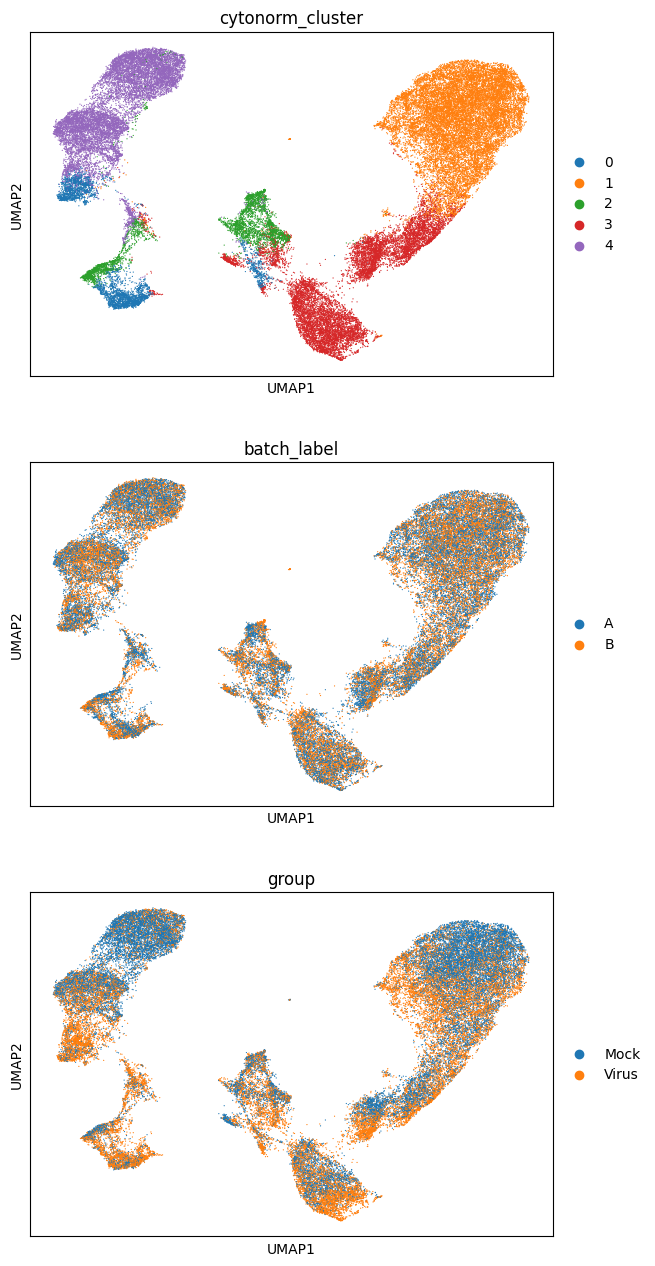

In [28]:
adata_sub = sc.pp.subsample(adata_all, n_obs = 50_000, copy = True)

sc.pp.neighbors(adata_sub, use_rep = 'normalised')

sc.tl.umap(adata_sub, min_dist = 0.1)

sc.pl.umap(
    adata_sub, 
    layer = 'normalised', 
    color = ['cytonorm_cluster', 'batch_label', 'group'], 
    size = 3, 
    ncols = 1
)

We can see the batches are now much more superimposed over each other. The cytonorm clusters do an ok job of capturing the broad cell types. But while looking an a UMAP gives a quick overview, it's a good idea to compare the parameter distributions pre-and post normalisation for the batch control files. First, let's create a new `AnnData` object containing just the data from the batch control samples.

In [29]:
adata_ref = adata_all[adata_all.obs['reference'] == 'ref']
adata_ref

View of AnnData object with n_obs × n_vars = 20000 × 8
    obs: 'filename', 'sample', 'group', 'batch_label', 'batch', 'reference', 'cytonorm_cluster'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    obsm: 'normalised'
    layers: 'original', 'normalised'

Next, we create separate DataFrames containing the original and normalised expression data. We add columns indicating whether the data are original or normalised, and the batch number for each event. Finally, we concatenate these together into a single DataFrame called `both`. 

In [30]:
orig = adata_ref.to_df(layer = 'original')
orig['group'] = 'original'
orig['batch'] = adata_ref.obs.batch

norm = adata_ref.to_df(layer = 'normalised')
norm['group'] = 'normalised'
norm['batch'] = adata_ref.obs.batch

both = pd.concat([orig, norm])
both

CD3e      CD16-32         Ly6G         CD45         CD48  \
0      1141.502801  1884.283173   631.694678  2096.491398  2345.868626   
1      1146.759063  1001.825654   911.361470  1859.862764  1385.111571   
2      1147.575687  2237.875240   844.361401  2068.902565  1974.999994   
3      1329.867442  2329.289555   791.594765  1443.450031  2116.643027   
4      1043.718253  2040.863053   342.438555  1501.455922  2602.254838   
...            ...          ...          ...          ...          ...   
49995  1093.597985  1253.195038   -48.364905  2676.159933  2916.001651   
49996  1198.776982  2779.748414  3323.263529  2151.755543  1519.962398   
49997  1473.892663  2433.838854  1060.009231  1707.809461  1881.749736   
49998  1307.985890  2601.736766  2882.050968  2027.890835   929.216557   
49999  1088.871324  2792.563676  3106.601275  1940.889623  1197.101574   

             CD11b         B220         Ly6C       group  batch  
0      1541.958951  3431.587756  1197.512280    original      1  
1      1323.273261  3219.384459  1711.602316    original      1  
2      2711.006654  1238.627796  2597.616532    original      1  
3      3098.270045  1792.858119  2867.574559    original      1  
4      2053.469957  2690.738776  1301.960150    original      1  
...            ...          ...          ...         ...    ...  
49995  1291.851753  3187.865781  1560.876894  normalised      2  
49996  3228.117012  1025.970601  2422.467398  normalised      2  
49997  2775.319616  1575.442517  2821.307012  normalised      2  
49998  3308.465222  1435.532210  2285.653496  normalised      2  
49999  3130.648391  1129.639749  2035.476600  normalised      2  

[40000 rows x 10 columns]

Now we have this DataFrame of annotated, batch control data, we use the `joyplot()` function from the package of the same name, to visualise the parameter distributions. As you scan through, you'll noice some discrepancies between the distributions pre-normalisation, that are corrected by cytonorm.

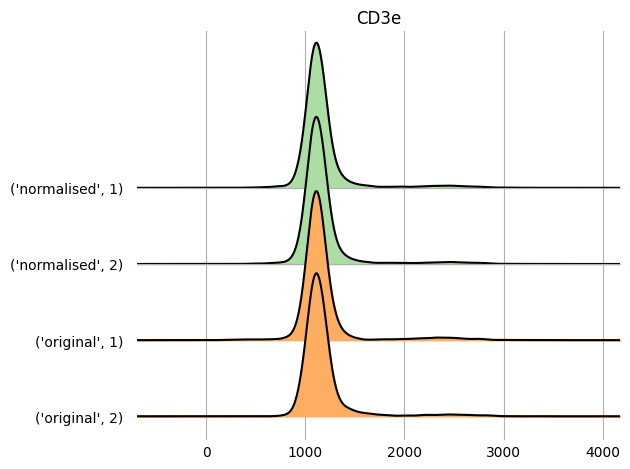

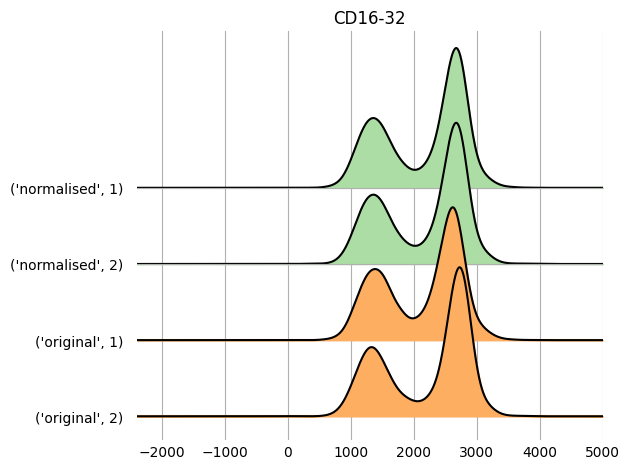

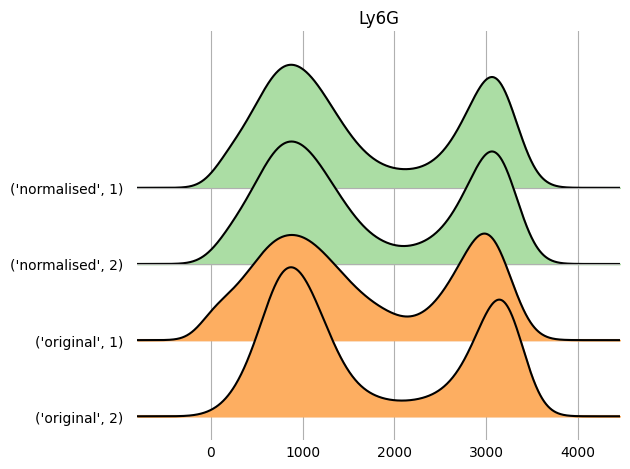

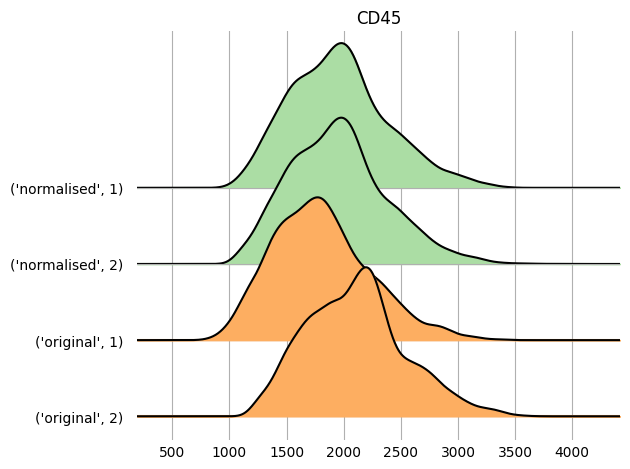

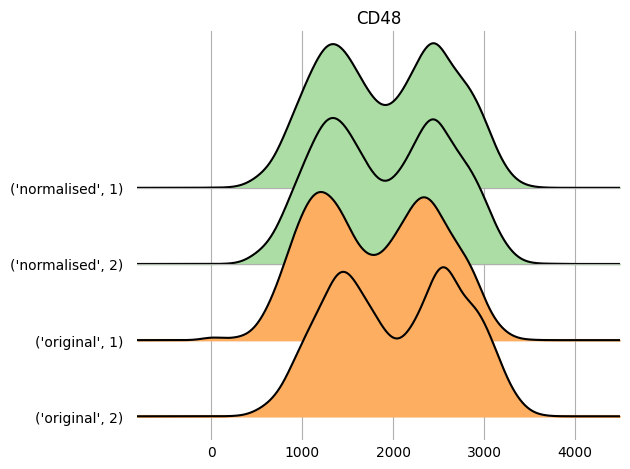

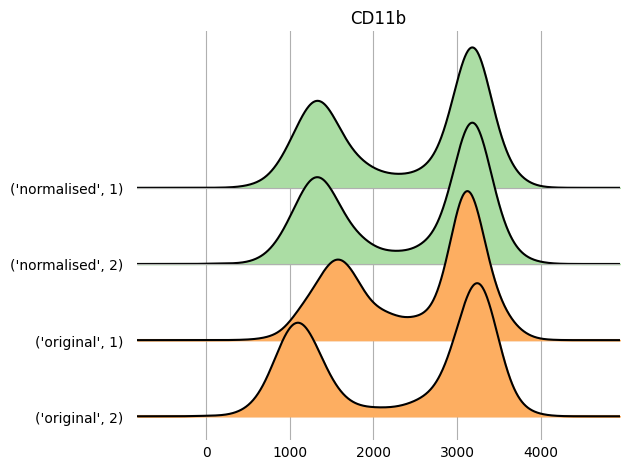

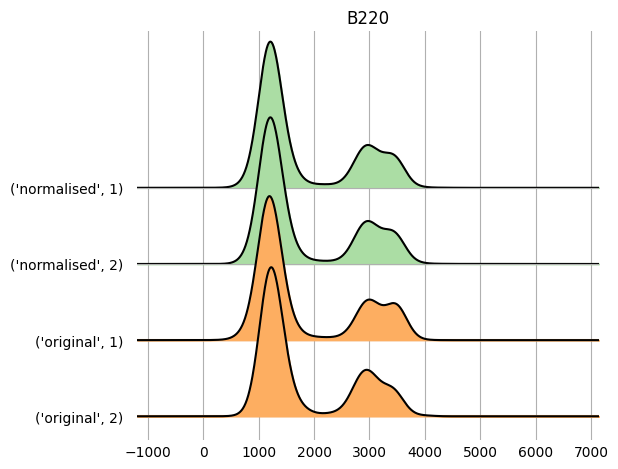

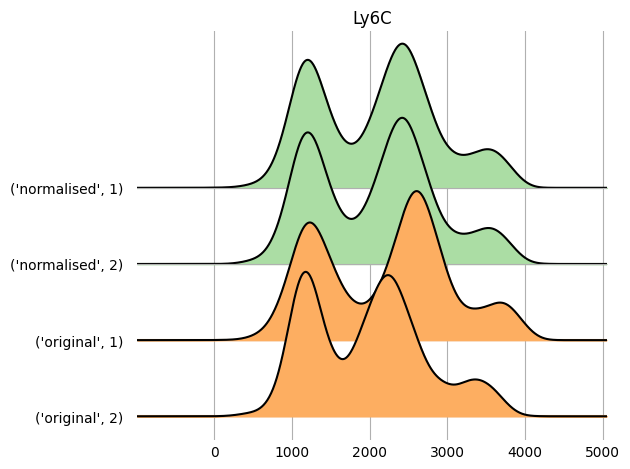

In [31]:
for param in adata.var_names.to_list():
    p = joypy.joyplot(
        both,
        title   = param,
        by      = ['group', 'batch'],
        column  = param,
        overlap = 1.5,
        grid    = True,
        color   = ['#ABDDA4', '#ABDDA4', '#FDAE61', '#FDAE61']
    )

If we weren't happy with the normalisation, we could go back and change the number of clusters, for example. But this looks as though the batch effect has been removed, so now let's replace the `X` expression matrix in our AnnData object with the normalised expression matrix.

In [32]:
adata_all.X = adata_all.layers['normalised']

## Clustering
To help us identify clusters or populations of cells in our data, we can employ a clustering algorithm to partition the events into groups that are more similar to each other than they are to events in other groups. Traditional gating is just "clustering by hand", but can be subjective and miss important populations when the parameter space is large.

The `pytometry` package currently only has an implementation of the FlowSOM clustering algorithm (which is probably the most widely used), but there are Python implementations of other clustering algorithms you could apply, such as [phenograph](https://github.com/dpeerlab/phenograph). FlowSOM and phenograph are state of the art and perform well for most cytometry clustering problems. In this example we'll use FlowSOM. 

Performing FlowSOM clustering is easy: we simply provide the `AnnData` object as the first argument, the name of the column that will indicate cluster membership in `obs`, and arguments that control the clustering algorithm. 

The `som_dim` controls the dimensions of the [self organizing map ](https://en.wikipedia.org/wiki/Self-organizing_map). The greater the dimensions of the SOM, the more initial clusters the data are broken up into. The default is `(10, 10)`, but here I set it to `(15, 15)` as it seems to result in better clustering. We can set the random `seed` to ensure reproducibility (pick your favourite number of leave the default of 42), and the `min_clusters` and `max_clusters` arguments. If these have the same value, we are essentially instructing FlowSOM to return exactly that number of metaclusters. Otherwise, we can give the algorithm different minimum and maximum numbers, and let it choose for us (it tends to under cluster). It is usually best to set the number of metaclusters a little higher than the number of populations you think may be identifiable in the data (as we can easily merge clusters). We can alter the number of metaclusters later if we believe we are under or over clustering.

In [33]:
pm.tl.flowsom_clustering(
    adata_all,
    key_added    = 'fsom_metacluster',
    som_dim      = (15, 15),
    seed         = 24601,
    min_clusters = 15,
    max_clusters = 15,
    verbose      =  True
)

 [ 500 / 500 ] 100% - 0:00:00 left 


 quantization error: 650.0046638720019


Computing consensus matrices:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Python_3.10.2\lib\site-packages\kneed\knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
c:\Python_3.10.2\lib\site-packages\kneed\knee_locator.py:208: RuntimeWarning: Mean of empty slice.
  self.S * np.abs(np.diff(self.x_normalized).mean())
c:\Python_3.10.2\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python_3.10.2\lib\site-packages\consensusclustering\consensus.py:464: UserWarning: Kneedle algorithm failed to find a knee. Returning maximum number of clusters, however, it is likely that the clustering is unstable. Plot the CDFs and consensus matrices to check.
  warn(


Assigning cluster labels to cells:   0%|          | 0/160000 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 160000 × 8
    obs: 'filename', 'sample', 'group', 'batch_label', 'batch', 'reference', 'cytonorm_cluster', 'fsom_metacluster'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    obsm: 'normalised'
    layers: 'original', 'normalised'

We can access the cluster memberships from the `fsom_metacluster` column from `obs`. Below we just show we do indeed have 15 metaclusters.

In [34]:
len(adata_all.obs['fsom_metacluster'].unique())

15

Let's subsample the data and calculate the UMAP embedding again, so we can colour the points by metacluster. 

c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


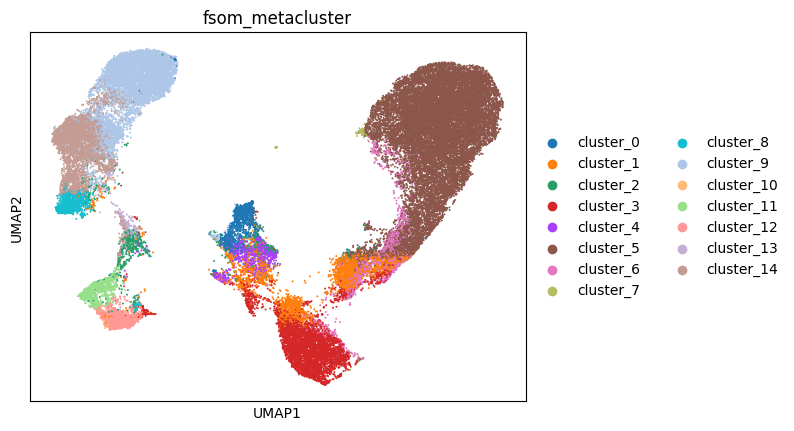

In [35]:
adata_sub = sc.pp.subsample(adata_all, n_obs = 50_000, copy = True)

sc.pp.neighbors(adata_sub)

sc.tl.umap(adata_sub, min_dist = 0.1)

sc.pl.umap(adata_sub, color = 'fsom_metacluster', size = 8)

Finally, to help us assign cell types to our clusters ("annotating" the clusters), let’s plot the UMAP embeddings, but faceting by antigen, and colouring by expression of that antigen.

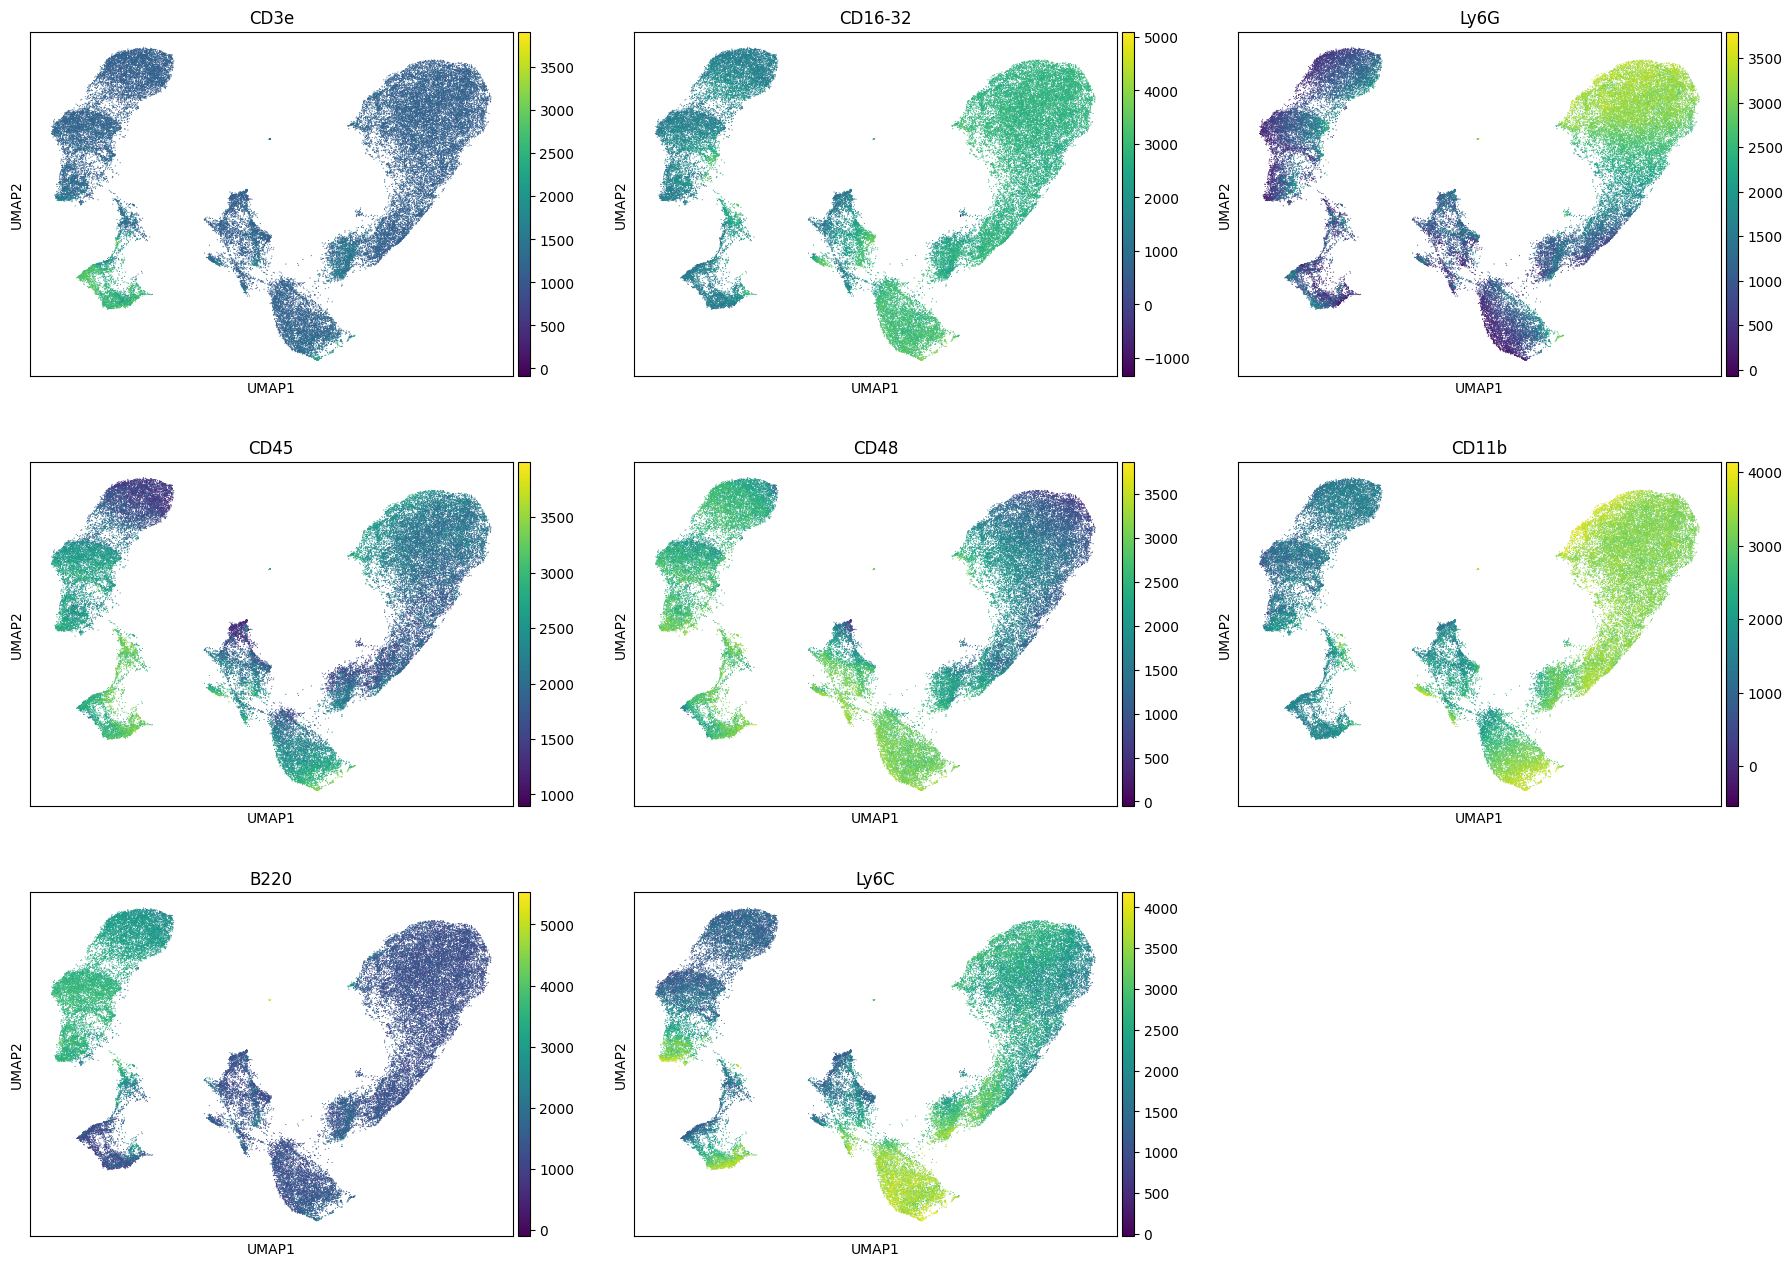

In [36]:
sc.pl.umap(
    adata_sub,
    gene_symbols = 'marker',
    color        = adata_sub.var_names,
    ncols        = 3
)

We can also create bivariate plots, colouring by metacluster, as this may help us when annotating the clusters later. Below we plot every parameter against CD45.

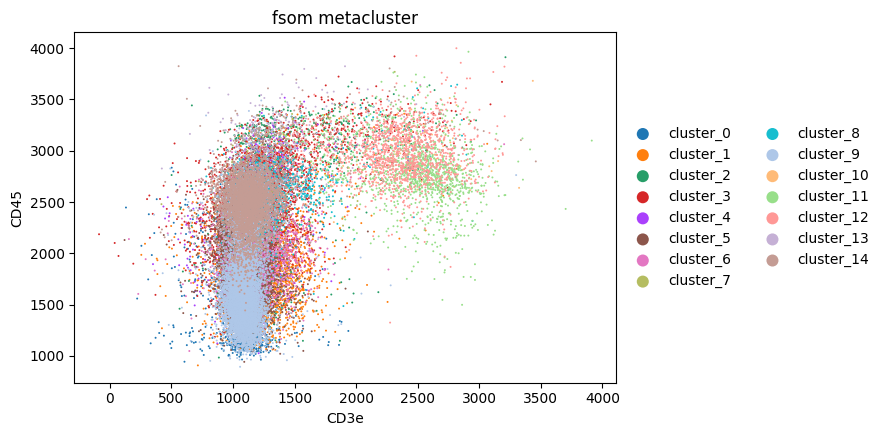

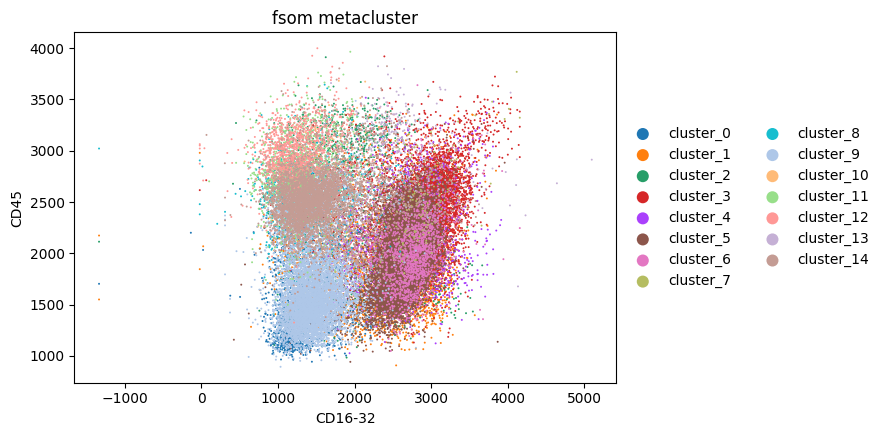

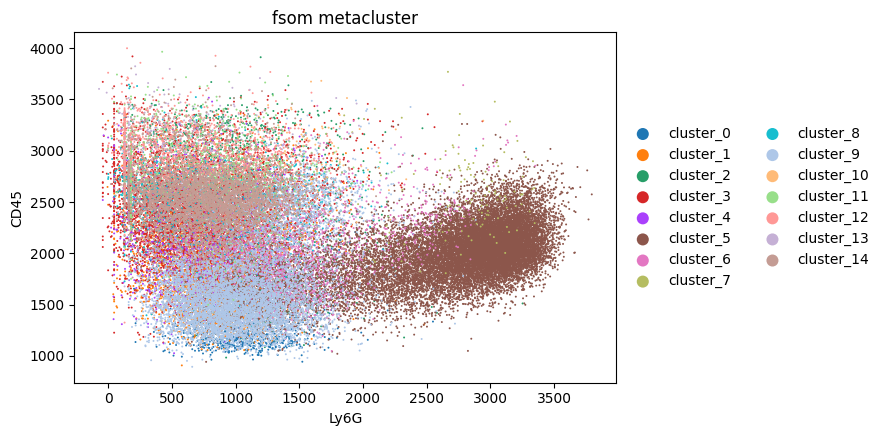

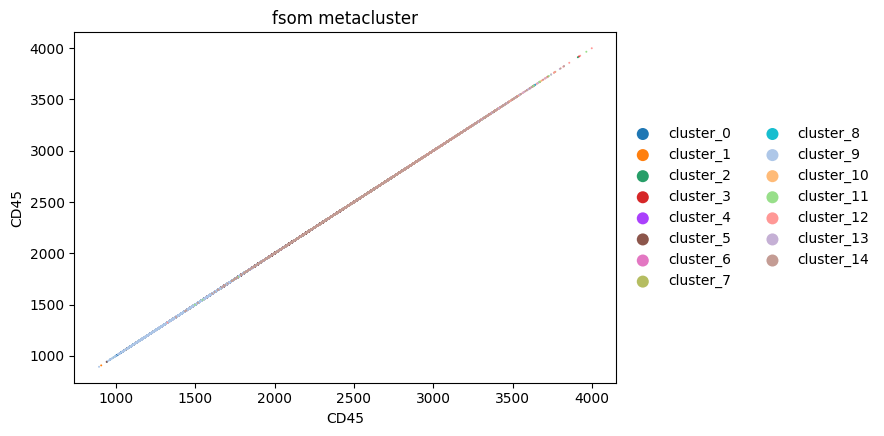

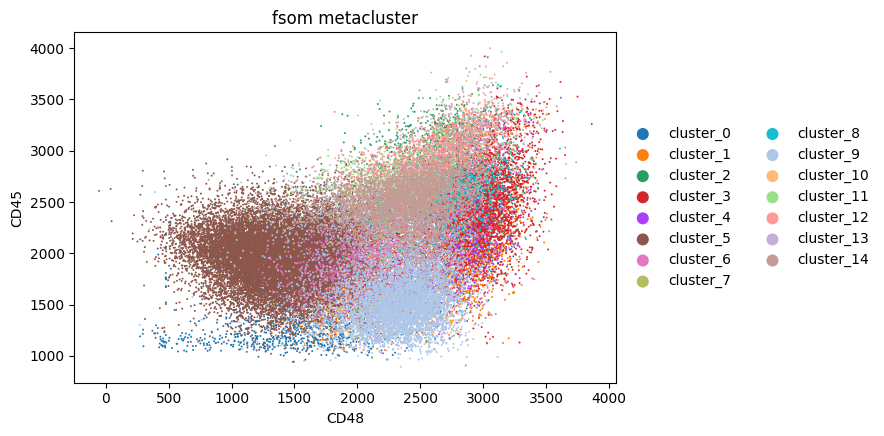

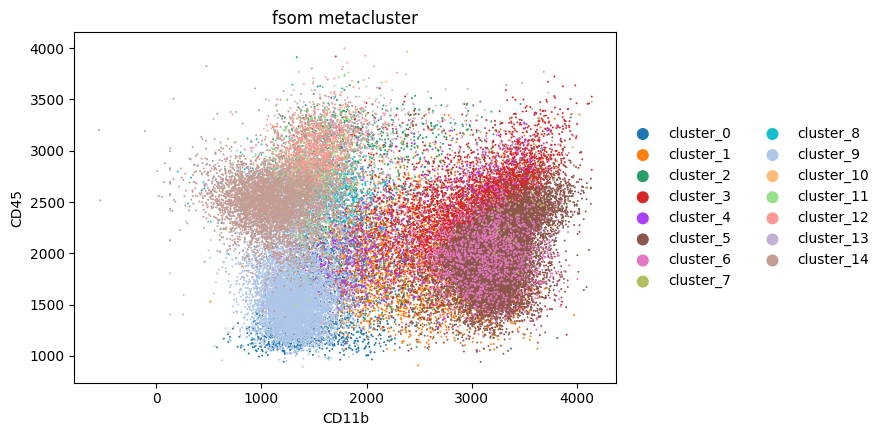

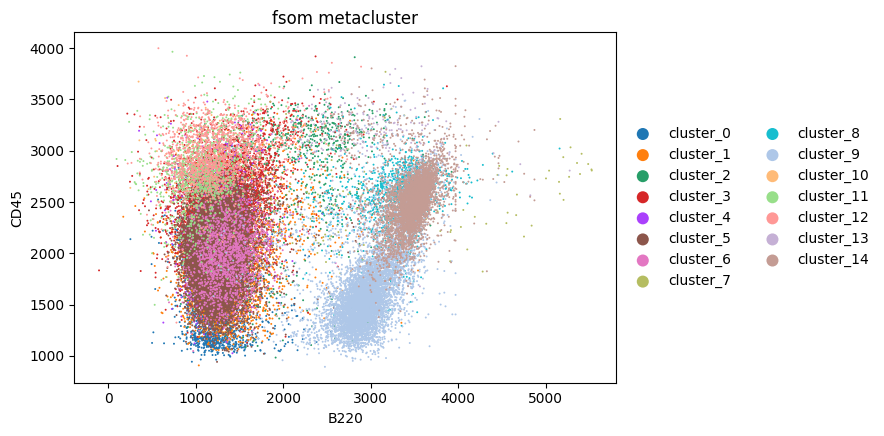

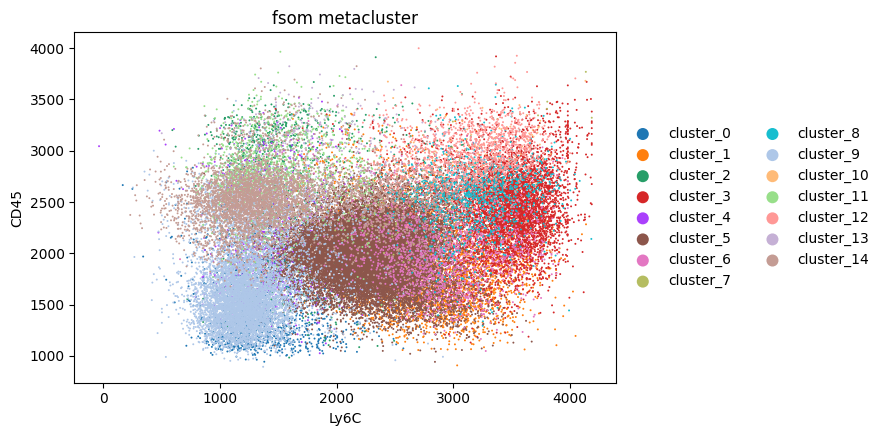

In [37]:
for param in adata_sub.var_names:
    sc.pl.scatter(adata_sub, x = param, y = 'CD45', color = 'fsom_metacluster', size = 8, )

## Annotating our clusters
The process of assigning a biological cell type to each cluster is usually the hardest and most labour intensive part of the analysis. To help with this, in addition to the UMAP plots we created a moment ago, `scanpy` provides us with a few different visualisation tools. You may not like all of them, but we'll look at them here one by one so you have a feeel of what's available.

Let's start with what `scanpy` calls a dotplot, which is a heatmap where the size of each "dot" is mapped to an estimate of the proportion of events positive for each marker. This is calculated based on a single expression cutoff value, which for the example we set to 2000.

c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


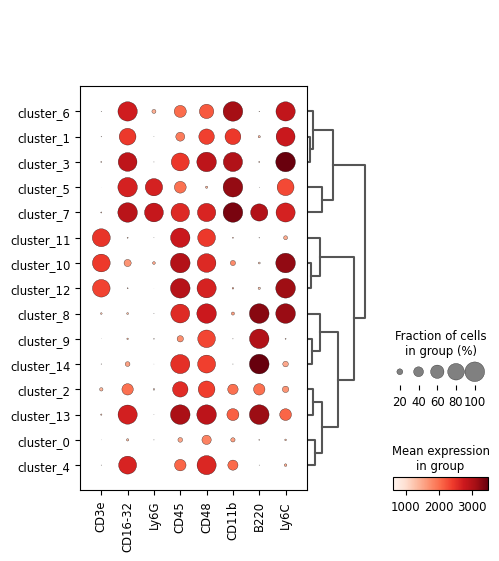

In [38]:
sc.pl.dotplot(
    adata_all, 
    var_names         = adata_all.var_names, 
    groupby           = 'fsom_metacluster', 
    dendrogram        = True,
    expression_cutoff = 2000
)

Another way to visualize metacluster expression is through violin plots. Here we iterate through each parameter and visualize its distribution per metacluster with violin plots. Setting `stripplot = False` suppresses the drawing of individual events, and speeds up plotting. These plots are also useful for identifying under-clustering, where we may see bimodal or even multimodal parameter distributions.

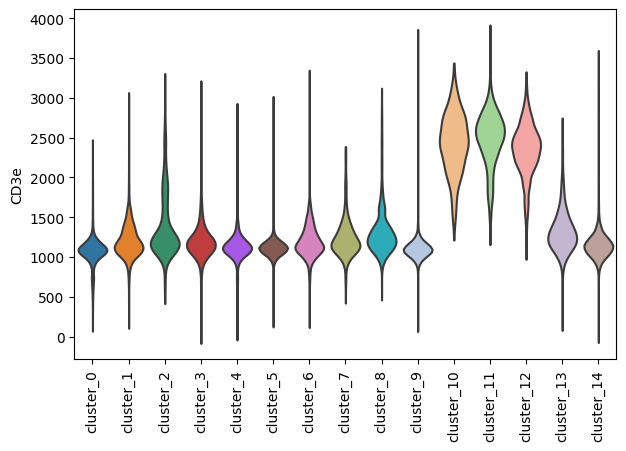

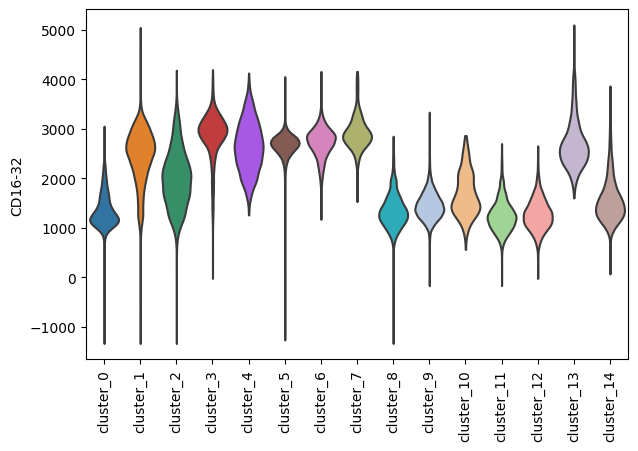

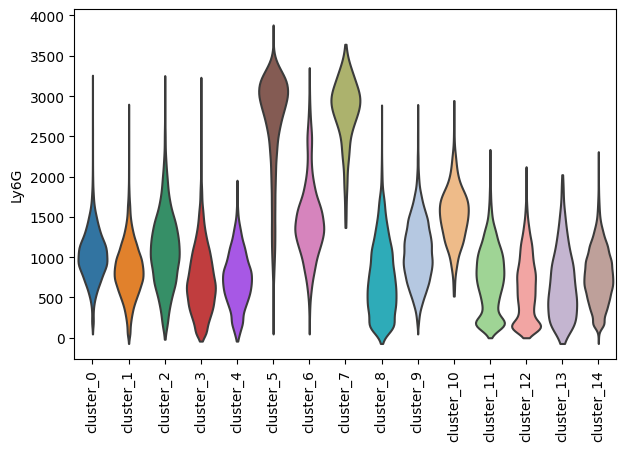

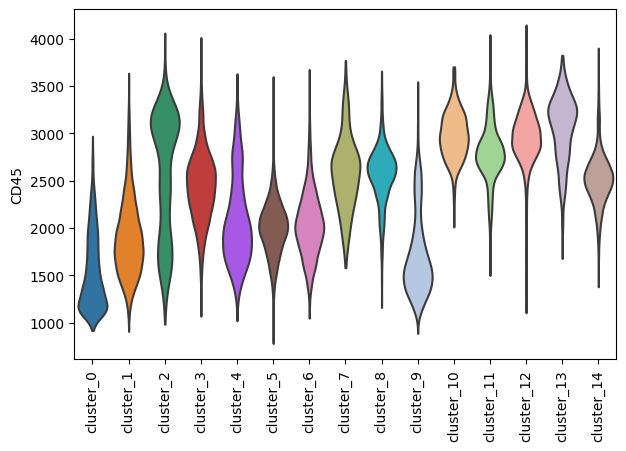

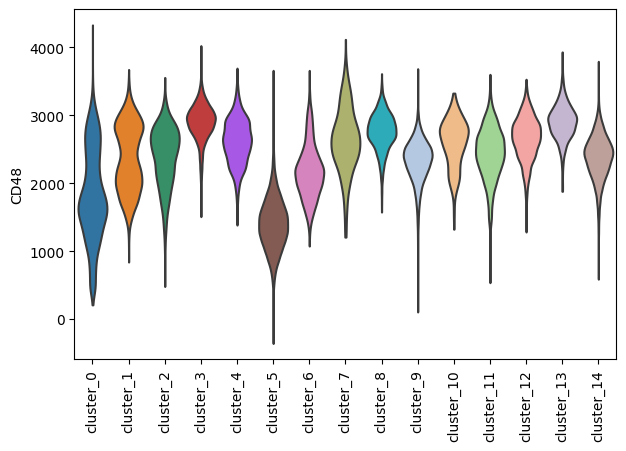

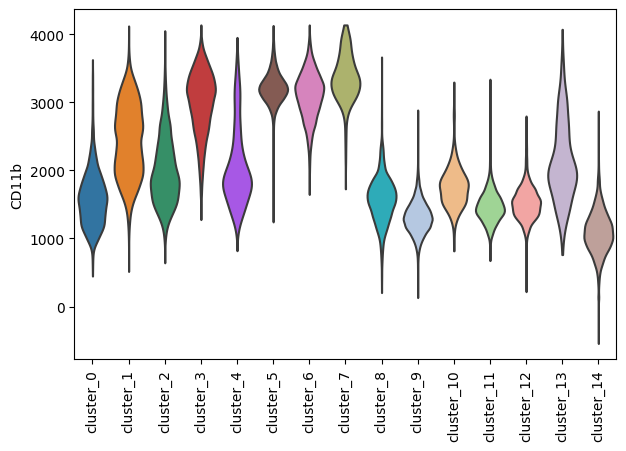

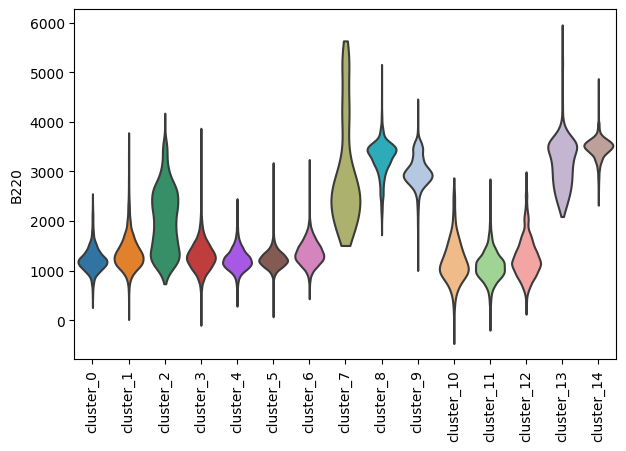

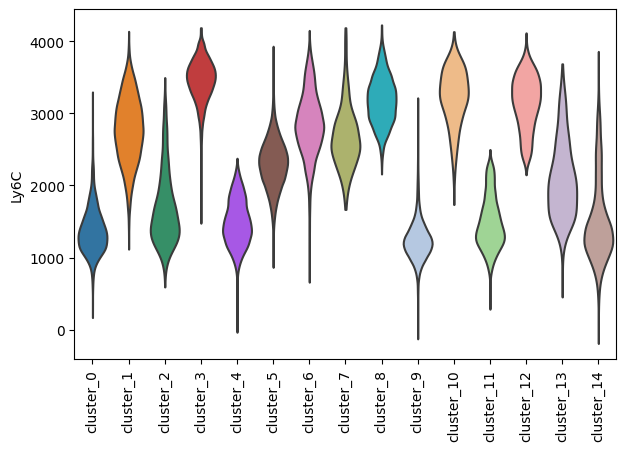

In [39]:
for param in adata_all.var_names:
    sc.pl.violin(
    adata_all, 
    keys      = param, 
    groupby   = 'fsom_metacluster', 
    rotation  = 90,
    stripplot = False    
)

But the visualisation many people are more comfortable with is the humble heatmap, which `scanpy` calls a matrixplot.

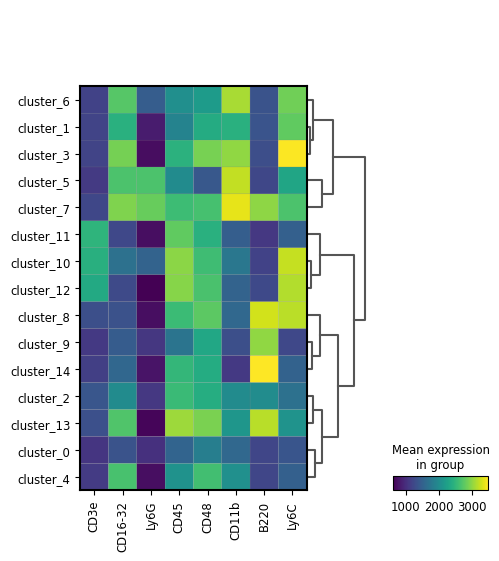

In [40]:
sc.pl.matrixplot(
    adata_all, 
    var_names  = adata_all.var_names, 
    groupby    = 'fsom_metacluster', 
    dendrogram = True
)

The heatmap above is displaying the mean of the transformed parameter values per metacluster. But it's also useful to scale the expression values between 0 and 1 within each column (parameter) first, to visualise the metaclusters expressing the most and least amount of each antigen. We do this by providing `standard_scale = 'var'` (to do the same within each column, set this argument to `'group'`, but this isn't as useful).

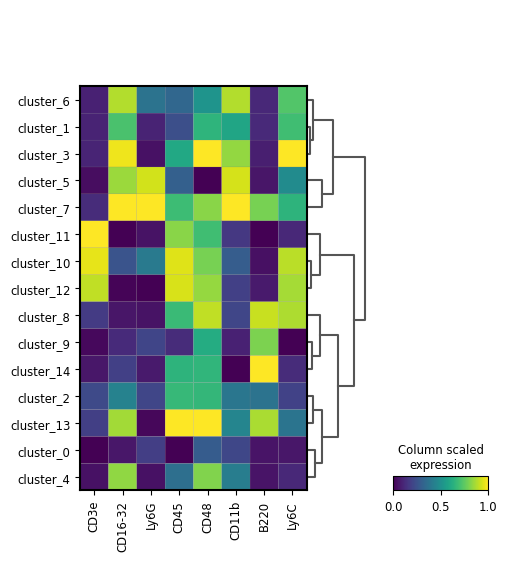

In [41]:
sc.pl.matrixplot(
    adata_all, 
    var_names      = adata_all.var_names, 
    groupby        = 'fsom_metacluster', 
    dendrogram     = True,
    standard_scale = 'var',
    colorbar_title = 'Column scaled\nexpression'
)

The visualization `scanpy` calls a heatmap is similar to the visualization above, except that every individual event is included in the plot. The only useful thing about this is that we can clearly see the proportion of total each metacluster represents, and we can use this information to inform cell type annotations.

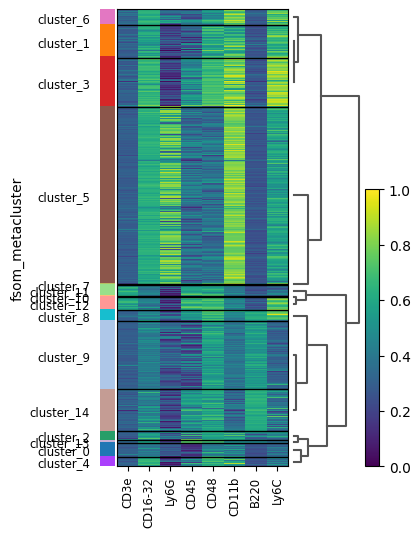

In [42]:
sc.pl.heatmap(
    adata_all, 
    var_names      = adata_all.var_names, 
    groupby        = 'fsom_metacluster', 
    standard_scale = 'var',
    dendrogram     = True
)

Armed with our visualisations above, now we need to start assigning cell types to our FlowSOM metaclusters. Note that it’s better to over cluster than to under cluster, as at this point we can merge clusters we believe represent the same cell type.

To annotate, we create a dictionary of key:value pairs, where the key of each element is the name of the metacluster, and the value of each element is cell type we wish to assign to that metacluster.

Once we have created our dictionary, we use the `map()` method on the `fsom_metacluster` column, which looks at each value of that column, finds the corresponding key in the dictionary we provide as an argument, and pulls out the value. This is then returned as a single series which we assign as a column of the `obs` subfield.

In [43]:
annotations = {
    'cluster_0'  : 'Other/Unknown',
    'cluster_1'  : 'Monocytes',
    'cluster_2'  : 'Other/Unknown',
    'cluster_3'  : 'Monocytes',
    'cluster_4'  : 'Other/Unknown',
    'cluster_5'  : 'Mature neutrophils',
    'cluster_6'  : 'Immature neutrophils',
    'cluster_7'  : 'Mature neutrophils',
    'cluster_8'  : 'Plasma cells',
    'cluster_9'  : 'B cells',
    'cluster_10' : 'T cells',
    'cluster_11' : 'T cells',
    'cluster_12' : 'T cells',
    'cluster_13' : 'B cells',
    'cluster_14' : 'B cells',
}

adata_all.obs['population'] = adata_all.obs['fsom_metacluster'].map(annotations)
adata_all.obs

filename     sample  group batch_label  batch reference  \
0        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
1        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
2        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
3        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
4        Mock_01_A.fcs  Mock_01_A   Mock           A      1       ref   
...                ...        ...    ...         ...    ...       ...   
159995  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159996  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159997  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159998  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   
159999  Virus_08_B.fcs   WNV_08_B  Virus           B      2     other   

       cytonorm_cluster fsom_metacluster            population  
0                     4       cluster_14               B cells  
1                     4        cluster_9               B cells  
2                     3        cluster_1             Monocytes  
3                     3        cluster_1             Monocytes  
4                     4        cluster_9               B cells  
...                 ...              ...                   ...  
159995                3        cluster_3             Monocytes  
159996                2       cluster_11               T cells  
159997                1        cluster_5    Mature neutrophils  
159998                1        cluster_5    Mature neutrophils  
159999                3        cluster_6  Immature neutrophils  

[160000 rows x 9 columns]

So we can create a nice UMAP plot labelled with our cell types, let’s do the same for the `adata_sub` DataFrame, then plot the UMAP embedding with the cell type labels.

c:\Python_3.10.2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


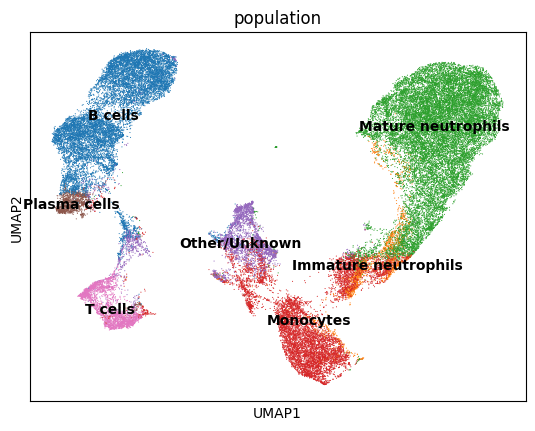

In [44]:
adata_sub.obs['population'] = adata_sub.obs['fsom_metacluster'].map(annotations)
sc.pl.umap(adata_sub, color = 'population', legend_loc = 'on data')

Lastly, let’s recreate our expression heatmaps using our annotated cell types as rows, instead of the metaclusters.

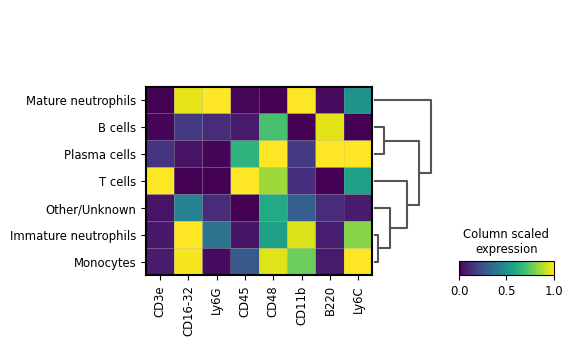

In [45]:
sc.pl.matrixplot(
    adata_all, 
    var_names      = adata_all.var_names, 
    groupby        = 'population', 
    dendrogram     = True,
    standard_scale = 'var',
    colorbar_title = 'Column scaled\nexpression'
)

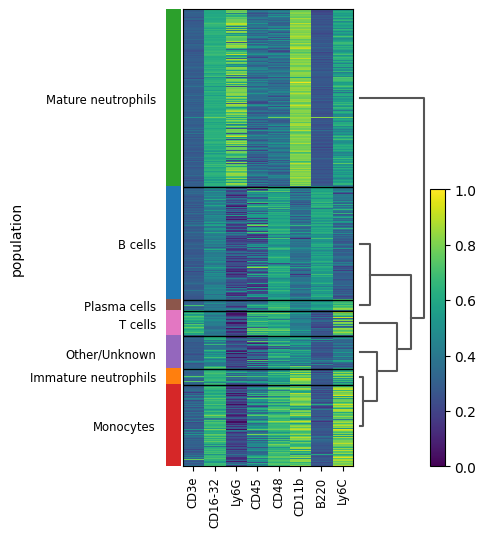

In [46]:
sc.pl.heatmap(
    adata_all, 
    var_names      = adata_all.var_names, 
    groupby        = 'population', 
    standard_scale = 'var',
    dendrogram     = True
)

## Exporting the data
Now that our original .fcs data are combined and annotated with the metadata and population data, it’s a good idea to save a snapshot so we can come back to where we left off in future. The `write_csvs()` method will write seperate .csv files for each subfield of our AnnData object, while the `write()` method stores the entire object as a .h5ad file, which is `AnnData`'s file format. We can read in an `AnnData` object from its .h5ad file using the `read_h5ad()` function (I do this just as a demonstration below).

In [47]:
adata_all.write_csvs('data/exported/annotated')
adata_all.write('data/exported/annotated.h5ad')
adata_2 = ann.read_h5ad('data/exported/annotated.h5ad')
adata_2

AnnData object with n_obs × n_vars = 160000 × 8
    obs: 'filename', 'sample', 'group', 'batch_label', 'batch', 'reference', 'cytonorm_cluster', 'fsom_metacluster', 'population'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', 'signal_type'
    uns: 'dendrogram_fsom_metacluster', 'dendrogram_population', 'fsom_metacluster_colors', 'population_colors'
    obsm: 'normalised'
    layers: 'normalised', 'original'

## Statistical analysis
So far we have partitioned our dataset into populations of cells. Now what? The next step in your analysis will depend on the questions you are asking, but a general starting point is to generate summary statistics of our data that include:

- the proportion of all events in each population
- the median fluorescence/mass intensity (MFI) of each antigen within population

### Generating summary statistics


In [65]:
percentages = pd.crosstab(adata_all.obs['sample'], adata_all.obs['population'], normalize = 'index') * 100
percentages

population  B cells  Immature neutrophils  Mature neutrophils  Monocytes  \
sample                                                                     
Mock_01_A     29.87                  1.50               43.60      12.53   
Mock_02_A     31.57                  1.82               42.13      11.51   
Mock_03_A     31.82                  1.90               40.36      13.22   
Mock_04_A     31.60                  2.18               41.10      13.27   
Mock_05_B     30.42                  2.12               44.06      12.31   
Mock_06_B     31.08                  1.64               43.07      12.93   
Mock_07_B     29.99                  1.92               42.56      12.22   
Mock_08_B     29.85                  3.04               43.87      14.88   
WNV_01_A      16.26                  4.01               35.93      24.68   
WNV_02_A      16.30                  4.75               33.96      26.21   
WNV_03_A      23.64                  4.71               29.93      24.62   
WNV_04_A      17.66                  4.58               39.70      19.59   
WNV_05_B      14.68                  6.69               35.84      26.16   
WNV_06_B      22.34                  4.61               35.54      18.67   
WNV_07_B      18.21                  5.12               36.67      20.97   
WNV_08_B      19.88                  5.74               34.35      21.94   

population  Other/Unknown  Plasma cells  T cells  
sample                                            
Mock_01_A            6.76          1.51     4.23  
Mock_02_A            7.65          1.34     3.98  
Mock_03_A            7.54          1.31     3.85  
Mock_04_A            7.00          1.42     3.43  
Mock_05_B            6.87          1.06     3.16  
Mock_06_B            6.51          1.14     3.63  
Mock_07_B            6.58          1.00     5.73  
Mock_08_B            5.97          0.35     2.04  
WNV_01_A             7.76          3.81     7.55  
WNV_02_A             7.96          4.08     6.74  
WNV_03_A             7.09          4.22     5.79  
WNV_04_A             6.25          4.12     8.10  
WNV_05_B             7.81          2.44     6.38  
WNV_06_B             7.53          2.99     8.32  
WNV_07_B             7.36          3.31     8.36  
WNV_08_B             7.40          2.94     7.75

In [55]:
grouped = adata_all.obs.groupby(['sample', 'population'])

out = pd.DataFrame(
    np.zeros((adata_all.shape[1], len(grouped))),
    columns = grouped.groups.keys(),
    index   = adata_all.var_names
)

for group, idx in grouped.indices.items():
    X = adata_all[idx].X
    out[group] = X.mean(axis = 0)

out

Mock_01_A                                                       \
             B cells Immature neutrophils Mature neutrophils    Monocytes   
CD3e     1110.204240          1207.099293        1120.065311  1179.032295   
CD16-32  1474.087792          2596.607416        2614.914126  2645.985287   
Ly6G      958.045444          1418.023552        2734.859869   765.676808   
CD45     1870.101967          1876.009182        1921.690984  2013.061561   
CD48     2344.672897          2140.861179        1295.229067  2636.718715   
CD11b    1275.781899          3042.833832        3194.222445  2773.503631   
B220     3119.837652          1324.211521        1229.633487  1294.225088   
Ly6C     1237.295348          3019.657159        2399.660043  3228.789853   

                                                   Mock_02_A  \
        Other/Unknown Plasma cells      T cells      B cells   
CD3e      1125.311287  1247.101791  2269.925276  1117.814246   
CD16-32   1923.427662  1372.176015  1238.931367  1439.733461   
Ly6G       970.108939   797.704170   609.951176   954.611300   
CD45      1910.740151  2459.496437  2723.160503  1813.775197   
CD48      2182.410419  2848.565148  2599.569774  2333.569971   
CD11b     1867.895613  1721.763078  1479.114509  1311.059771   
B220      1396.161678  3190.361458  1137.067635  3125.758208   
Ly6C      1386.908603  3122.249650  2232.111605  1238.775755   

                                                 ...      WNV_07_B  \
        Immature neutrophils Mature neutrophils  ... Other/Unknown   
CD3e             1205.157284        1123.463343  ...   1245.388719   
CD16-32          2681.317601        2621.376845  ...   1963.815942   
Ly6G             1459.882313        2640.728976  ...    937.114268   
CD45             1797.753854        1855.010828  ...   2152.247113   
CD48             2037.744530        1314.695624  ...   2234.243330   
CD11b            3040.764992        3191.836697  ...   1880.698389   
B220             1299.521340        1222.156861  ...   1549.601353   
Ly6C             2970.087155        2415.355380  ...   1561.353447   

                                      WNV_08_B                       \
        Plasma cells      T cells      B cells Immature neutrophils   
CD3e     1444.630091  2482.410496  1135.331088          1166.746005   
CD16-32  1301.366067  1311.074582  1593.501368          2706.361196   
Ly6G      782.728087   831.416275   915.855468          1524.260843   
CD45     2612.884458  2938.878014  2371.893360          2126.505213   
CD48     2637.019527  2481.964007  2290.220949          2245.168471   
CD11b    1473.704903  1555.665184  1198.821866          3148.989116   
B220     3355.761355  1294.638512  3403.288179          1365.881814   
Ly6C     3326.039554  2595.486927  1577.350287          2776.130845   

                                                                    \
        Mature neutrophils    Monocytes Other/Unknown Plasma cells   
CD3e           1098.736762  1212.410719   1236.598676  1458.722172   
CD16-32        2646.563069  2688.532475   1845.256195  1284.210227   
Ly6G           2424.288071   765.883317    930.278581   672.714485   
CD45           2038.724912  2376.529840   2115.787493  2660.567334   
CD48           1544.408893  2757.790847   2223.741138  2681.868512   
CD11b          3217.268570  2777.665532   1865.126480  1470.121454   
B220           1286.771693  1361.945634   1494.296832  3317.537116   
Ly6C           2236.906129  3184.315018   1572.780973  3307.688008   

                      
             T cells  
CD3e     2487.632042  
CD16-32  1313.930987  
Ly6G      786.202080  
CD45     2959.591479  
CD48     2492.711555  
CD11b    1552.852261  
B220     1292.095881  
Ly6C     2595.408805  

[8 rows x 112 columns]

In [60]:
out = pd.DataFrame(
    np.zeros((adata_all.shape[1], len(grouped))),
    columns = grouped.groups.keys(),
    index   = adata_all.var_names
)

out

Mock_01_A                                                    \
          B cells Immature neutrophils Mature neutrophils Monocytes   
CD3e          0.0                  0.0                0.0       0.0   
CD16-32       0.0                  0.0                0.0       0.0   
Ly6G          0.0                  0.0                0.0       0.0   
CD45          0.0                  0.0                0.0       0.0   
CD48          0.0                  0.0                0.0       0.0   
CD11b         0.0                  0.0                0.0       0.0   
B220          0.0                  0.0                0.0       0.0   
Ly6C          0.0                  0.0                0.0       0.0   

                                           Mock_02_A                       \
        Other/Unknown Plasma cells T cells   B cells Immature neutrophils   
CD3e              0.0          0.0     0.0       0.0                  0.0   
CD16-32           0.0          0.0     0.0       0.0                  0.0   
Ly6G              0.0          0.0     0.0       0.0                  0.0   
CD45              0.0          0.0     0.0       0.0                  0.0   
CD48              0.0          0.0     0.0       0.0                  0.0   
CD11b             0.0          0.0     0.0       0.0                  0.0   
B220              0.0          0.0     0.0       0.0                  0.0   
Ly6C              0.0          0.0     0.0       0.0                  0.0   

                            ...      WNV_07_B                      WNV_08_B  \
        Mature neutrophils  ... Other/Unknown Plasma cells T cells  B cells   
CD3e                   0.0  ...           0.0          0.0     0.0      0.0   
CD16-32                0.0  ...           0.0          0.0     0.0      0.0   
Ly6G                   0.0  ...           0.0          0.0     0.0      0.0   
CD45                   0.0  ...           0.0          0.0     0.0      0.0   
CD48                   0.0  ...           0.0          0.0     0.0      0.0   
CD11b                  0.0  ...           0.0          0.0     0.0      0.0   
B220                   0.0  ...           0.0          0.0     0.0      0.0   
Ly6C                   0.0  ...           0.0          0.0     0.0      0.0   

                                                                         \
        Immature neutrophils Mature neutrophils Monocytes Other/Unknown   
CD3e                     0.0                0.0       0.0           0.0   
CD16-32                  0.0                0.0       0.0           0.0   
Ly6G                     0.0                0.0       0.0           0.0   
CD45                     0.0                0.0       0.0           0.0   
CD48                     0.0                0.0       0.0           0.0   
CD11b                    0.0                0.0       0.0           0.0   
B220                     0.0                0.0       0.0           0.0   
Ly6C                     0.0                0.0       0.0           0.0   

                              
        Plasma cells T cells  
CD3e             0.0     0.0  
CD16-32          0.0     0.0  
Ly6G             0.0     0.0  
CD45             0.0     0.0  
CD48             0.0     0.0  
CD11b            0.0     0.0  
B220             0.0     0.0  
Ly6C             0.0     0.0  

[8 rows x 112 columns]

In [63]:
grouped.groups.keys()

dict_keys([('Mock_01_A', 'B cells'), ('Mock_01_A', 'Immature neutrophils'), ('Mock_01_A', 'Mature neutrophils'), ('Mock_01_A', 'Monocytes'), ('Mock_01_A', 'Other/Unknown'), ('Mock_01_A', 'Plasma cells'), ('Mock_01_A', 'T cells'), ('Mock_02_A', 'B cells'), ('Mock_02_A', 'Immature neutrophils'), ('Mock_02_A', 'Mature neutrophils'), ('Mock_02_A', 'Monocytes'), ('Mock_02_A', 'Other/Unknown'), ('Mock_02_A', 'Plasma cells'), ('Mock_02_A', 'T cells'), ('Mock_03_A', 'B cells'), ('Mock_03_A', 'Immature neutrophils'), ('Mock_03_A', 'Mature neutrophils'), ('Mock_03_A', 'Monocytes'), ('Mock_03_A', 'Other/Unknown'), ('Mock_03_A', 'Plasma cells'), ('Mock_03_A', 'T cells'), ('Mock_04_A', 'B cells'), ('Mock_04_A', 'Immature neutrophils'), ('Mock_04_A', 'Mature neutrophils'), ('Mock_04_A', 'Monocytes'), ('Mock_04_A', 'Other/Unknown'), ('Mock_04_A', 'Plasma cells'), ('Mock_04_A', 'T cells'), ('Mock_05_B', 'B cells'), ('Mock_05_B', 'Immature neutrophils'), ('Mock_05_B', 'Mature neutrophils'), ('Mock_05_B

In [64]:
expression_matrix = adata_all.X
samples = adata_all.obs['sample']
populations = adata_all.obs['population']
markers = adata_all.var_names

# Create a DataFrame from the expression matrix
df = pd.DataFrame(expression_matrix, columns=markers)
df['sample'] = samples.values
df['population'] = populations.values

# Calculate the median expression for each marker, cell type, and sample
summary_df = df.groupby(['sample', 'population']).median().reset_index()

# Reorganize the DataFrame if needed
summary_df = summary_df.melt(id_vars=['sample', 'population'], var_name='marker', value_name='median_expression')

print(summary_df)

        sample            population marker  median_expression
0    Mock_01_A               B cells   CD3e        1101.761309
1    Mock_01_A  Immature neutrophils   CD3e        1165.109258
2    Mock_01_A    Mature neutrophils   CD3e        1119.270504
3    Mock_01_A             Monocytes   CD3e        1162.399840
4    Mock_01_A         Other/Unknown   CD3e        1112.818261
..         ...                   ...    ...                ...
891   WNV_08_B    Mature neutrophils   Ly6C        2238.279776
892   WNV_08_B             Monocytes   Ly6C        3286.607718
893   WNV_08_B         Other/Unknown   Ly6C        1508.252040
894   WNV_08_B          Plasma cells   Ly6C        3303.251160
895   WNV_08_B               T cells   Ly6C        2808.743431

[896 rows x 4 columns]


0         Mock_01_A
1         Mock_01_A
2         Mock_01_A
3         Mock_01_A
4         Mock_01_A
            ...    
159995     WNV_08_B
159996     WNV_08_B
159997     WNV_08_B
159998     WNV_08_B
159999     WNV_08_B
Name: sample, Length: 160000, dtype: category
Categories (16, object): ['Mock_01_A', 'Mock_02_A', 'Mock_03_A', 'Mock_04_A', ..., 'WNV_05_B', 'WNV_06_B', 'WNV_07_B', 'WNV_08_B']

In [83]:
# Create a DataFrame from the expression matrix
df = pd.DataFrame(adata_all.X, columns = adata_all.var_names)
df['sample'] = adata_all.obs['sample'].values
df['population'] = adata_all.obs['population'].values

# Convert the 'population' column to string
df['population'] = df['population'].astype(str)

# Calculate the median expression for each marker, cell type, and sample
summary_df = df.groupby(['sample', 'population']).median().reset_index()

# Melt the DataFrame to have a long format
melted_df = summary_df.melt(
    id_vars = ['sample', 'population'], 
    var_name = 'marker', 
    value_name = 'median_expression'
)

# Create a new column combining marker and population
melted_df['marker_population'] = 'median_' + melted_df['marker'] + '_' + melted_df['population']

# Pivot the DataFrame
pivot_df = melted_df.pivot(
    index   = 'sample', 
    columns = 'marker_population', 
    values  = 'median_expression'
)

pivot_df.reset_index(inplace = True)

print(pivot_df)


marker_population     sample  median_B220_B cells  \
0                  Mock_01_A          3090.182943   
1                  Mock_02_A          3085.970961   
2                  Mock_03_A          3041.428383   
3                  Mock_04_A          3034.436092   
4                  Mock_05_B          3086.026846   
5                  Mock_06_B          3188.706530   
6                  Mock_07_B          3317.330232   
7                  Mock_08_B          3049.365297   
8                   WNV_01_A          3428.948815   
9                   WNV_02_A          3358.582495   
10                  WNV_03_A          3232.116295   
11                  WNV_04_A          3113.307588   
12                  WNV_05_B          3507.954731   
13                  WNV_06_B          3460.297173   
14                  WNV_07_B          3407.560131   
15                  WNV_08_B          3532.530264   

marker_population  median_B220_Immature neutrophils  \
0                                       130

In [80]:
adata_all.obs['population'].values

['B cells', 'B cells', 'Monocytes', 'Monocytes', 'B cells', ..., 'Monocytes', 'T cells', 'Mature neutrophils', 'Mature neutrophils', 'Immature neutrophils']
Length: 160000
Categories (7, object): ['B cells', 'Immature neutrophils', 'Mature neutrophils', 'Monocytes', 'Other/Unknown', 'Plasma cells', 'T cells']